 # DANN for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn
from torch.cuda.amp import GradScaler
from torch import autocast

from src.da_models.dann import DANN
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import load_spatial, load_sc, get_selected_dir
from src.utils.evaluation import format_iters

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_749372/3524933370.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
DATA_DIR = "data"
TRAIN_USING_ALL_ST_SAMPLES = False
N_MARKERS = 20
ALL_GENES = False

ST_SPLIT = False
N_MARKERS = 20
ALL_GENES = False
N_SPOTS = 20000
N_MIX = 8
SCALER_NAME = "standard"

SAMPLE_ID_N = "151673"

PRETRAINING = False
INITIAL_TRAIN_LR = 0.001
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100

BATCH_SIZE = 512

MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

MODEL_NAME = "DANN"
MODEL_VERSION = "Standard1"


In [4]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, MODEL_VERSION)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)


In [5]:
## Adversarial Hyperparameters

EPOCHS = 500
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ADV_LR = 2e-4

plateau_kwargs = {
    "patience": 50,
    "factor": 0.5,
    "min_lr": ADV_LR / 10,
    "verbose": True,
}
# PATIENCE = 20
# CHANGE_THRESHOLD = 0.001

ALPHA = 1
LAMBDA = 1
TWO_STEP = False

dann_kwargs = {
    "emb_dim": 64,
    "alpha_": ALPHA,
}
adv_opt_kwargs = {"lr": ADV_LR, "betas": (0.5, 0.999), "eps": 1e-07}


 # Data load

In [6]:
# Load spatial data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    train_using_all_st_samples=TRAIN_USING_ALL_ST_SAMPLES,
    st_split=ST_SPLIT,
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
)



 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [7]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if ST_SPLIT:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["val"])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["test"])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    target_test_set_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["test"])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )




 ## Pretrain

In [8]:
criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [9]:
# import itertools


# def plot_iters(nested_list, startpoint=False, endpoint=True, ax=None, **kwargs):
#     if ax is None:
#         ax = plt

#     x = []
#     if startpoint:
#         for i, l in enumerate(nested_list):
#             if endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=True, dtype=np.float32)
#             else:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=False, dtype=np.float32)
#             x.append(x_i)
#     else:
#         for i, l in enumerate(nested_list):
#             if not endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(
#                     i, i - 1, len(l + 1), endpoint=False, dtype=np.float32
#                 )
#                 x_i = x_i[1:]
#             else:
#                 x_i = np.linspace(i, i - 1, len(l), endpoint=False, dtype=np.float32)

#             # Flip to not include startpoint i.e. shift to end of iteration
#             x_i = np.flip(x_i)
#             x.append(x_i)

#     x = np.asarray(list(itertools.chain(*x)))
#     y = np.asarray(list(itertools.chain(*nested_list)))
#     ax.plot(x, y, **kwargs)

#     return x, y


In [10]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred, _ = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [11]:
if PRETRAINING:

    pretrain_folder = os.path.join(model_folder, "pretrain")

    model = DANN(
        inp_emb=sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        **dann_kwargs,
    )
    model.apply(initialize_weights)
    model.to(device)

    pre_optimizer = torch.optim.AdamW(
        model.parameters(), lr=INITIAL_TRAIN_LR, betas=(0.9, 0.999), eps=1e-07
    )

    pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        pre_optimizer,
        max_lr=INITIAL_TRAIN_LR,
        steps_per_epoch=len(dataloader_source_train),
        epochs=INITIAL_TRAIN_EPOCHS,
    )

    model.pretraining()

    if not os.path.isdir(pretrain_folder):
        os.makedirs(pretrain_folder)
    # Initialize lists to store loss and accuracy values
    loss_history = []
    loss_history_val = []

    loss_history_running = []

    lr_history_running = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    with DupStdout().dup_to_file(
        os.path.join(pretrain_folder, "log.txt"), "w"
    ) as f_log:
        print("Start pretrain...")
        outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
        inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

        print(" Epoch | Train Loss | Val Loss   | Next LR    ")
        print("----------------------------------------------")
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": pre_optimizer,
            "scheduler": pre_scheduler,
            # 'scaler': scaler
        }
        for epoch in range(INITIAL_TRAIN_EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            loss_running = []
            mean_weights = []
            lr_running = []

            inner.refresh()  # force print final state
            inner.reset()  # reuse bar
            for _, batch in enumerate(dataloader_source_train):
                lr_running.append(pre_scheduler.get_last_lr()[-1])

                pre_optimizer.zero_grad()
                loss = model_loss(*batch, model)
                loss_running.append(loss.item())
                mean_weights.append(
                    len(batch)
                )  # we will weight average by batch size later

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                pre_optimizer.step()
                pre_scheduler.step()

                inner.update(1)

            loss_history.append(np.average(loss_running, weights=mean_weights))
            loss_history_running.append(loss_running)
            lr_history_running.append(lr_running)

            # Evaluate mode
            model.eval()
            with torch.no_grad():
                curr_loss_val = compute_acc(dataloader_source_val, model)
                loss_history_val.append(curr_loss_val)

            # Print the results
            outer.update(1)

            print(
                f" {epoch:5d}",
                f"| {loss_history[-1]:<10.8f}",
                f"| {curr_loss_val:<10.8f}",
                f"| {pre_scheduler.get_last_lr()[-1]:<10.5}",
                end=" ",
            )

            # Save the best weights
            if curr_loss_val < best_loss_val:
                best_loss_val = curr_loss_val
                torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
                early_stop_count = 0

                print("<-- new best val loss")
            else:
                print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
                torch.save(
                    checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth")
                )

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
                print(
                    f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth")
                )
                break

            early_stop_count += 1

    lr_history_running[-1].append(pre_scheduler.get_last_lr()[-1])

    # Save final model
    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


In [12]:
if PRETRAINING:

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

    best_epoch = best_checkpoint["epoch"]
    best_loss_val = loss_history_val[best_epoch]

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 4), layout="constrained")

    axs[0].plot(*format_iters(loss_history_running), label="Training", linewidth=0.5)
    axs[0].plot(loss_history_val, label="Validation")
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=max(loss_history + loss_history_val) * 0.5,
        s=f"Best val. loss:\n{best_loss_val:.4f} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    # axs[0].set_xlabel("Epoch")
    axs[0].set_title("Cross-Entropy Loss")
    axs[0].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = format_iters(
        lr_history_running, startpoint=True
    )
    axs[1].plot(iters_by_epoch, lr_history_running_flat)
    axs[1].axvline(best_checkpoint["epoch"], ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[1].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Learning Rate")

    plt.savefig(os.path.join(pretrain_folder, "train_plots.png"), bbox_inches="tight")

    plt.show(block=False)


 ## Adversarial Adaptation

In [13]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [14]:
criterion_dis = nn.BCEWithLogitsLoss()


In [15]:
def model_adv_loss(x_source, x_target, y_source, model, two_step=False, optimizer=None):

    if optimizer is not None:
        optimizer.zero_grad()

    y_dis_source = torch.zeros(
        x_source.shape[0], device=device, dtype=x_source.dtype
    ).view(-1, 1)
    y_clf, y_dis_source_pred = model(x_source, clf=True)
    loss_clf = criterion_clf(y_clf, y_source)
    loss_dis_source = criterion_dis(y_dis_source_pred, y_dis_source)

    if two_step and optimizer is not None:
        loss = loss_clf + loss_dis_source * LAMBDA
        loss.backward()
        optimizer.step()

    y_dis_target = torch.ones(
        x_target.shape[0], device=device, dtype=x_target.dtype
    ).view(-1, 1)
    _, y_dis_target_pred = model(x_target, clf=False)
    loss_dis_target = criterion_dis(y_dis_target_pred, y_dis_target)

    if two_step and optimizer is not None:
        optimizer.zero_grad()
        loss = loss_dis_target * LAMBDA
        loss.backward()
        optimizer.step()
    elif optimizer is not None:
        loss = loss_clf + (loss_dis_source + loss_dis_target) * LAMBDA
        loss.backward()
        optimizer.step()

    accu_source = torch.mean(
        (
            torch.round(torch.sigmoid(y_dis_source_pred.detach())).to(torch.long)
            == y_dis_source.detach()
        ).to(torch.float32)
    ).cpu()

    accu_target = torch.mean(
        (
            torch.round(torch.sigmoid(y_dis_target_pred.detach())).to(torch.long)
            == y_dis_target.detach()
        ).to(torch.float32)
    ).cpu()

    return (loss_dis_source, loss_dis_target, loss_clf), (accu_source, accu_target)


def run_epoch(
    dataloader_source,
    dataloader_target,
    model,
    optimizer=None,
    tqdm_bar=None,
    two_step=False,
):
    source_results = {}
    target_results = {}

    source_results["clf_loss"] = []
    source_results["dis_loss"] = []
    source_results["dis_accu"] = []
    source_results["weights"] = []

    target_results["dis_loss"] = []
    target_results["dis_accu"] = []
    target_results["weights"] = []

    n_iters = max(len(dataloader_source), len(dataloader_target))

    s_iter = iter(dataloader_source)
    t_iter = iter(dataloader_target)
    for i in range(n_iters):
        try:
            x_source, y_source = next(s_iter)
        except StopIteration:
            s_iter = iter(dataloader_source)
            x_source, y_source = next(s_iter)
        try:
            x_target, _ = next(t_iter)
        except StopIteration:
            t_iter = iter(dataloader_target)
            x_target, _ = next(t_iter)

        x_source = x_source.to(torch.float32).to(device)
        x_target = x_target.to(torch.float32).to(device)
        y_source = y_source.to(torch.float32).to(device)

        (loss_dis_source, loss_dis_target, loss_clf), (
            accu_source,
            accu_target,
        ) = model_adv_loss(
            x_source, x_target, y_source, model, two_step=two_step, optimizer=optimizer
        )

        source_results["dis_loss"].append(loss_dis_source.item())
        target_results["dis_loss"].append(loss_dis_target.item())
        source_results["clf_loss"].append(loss_clf.item())

        source_results["dis_accu"].append(accu_source)
        target_results["dis_accu"].append(accu_target)

        source_results["weights"].append(len(x_source))
        target_results["weights"].append(len(x_target))

        if tqdm_bar is not None:
            tqdm_bar.update(1)

    return source_results, target_results


In [16]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
):
    model.to(device)
    model.advtraining()

    optimizer = torch.optim.AdamW(model.parameters(), **adv_opt_kwargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **plateau_kwargs)

    max_len_dataloader = max(len(dataloader_source_train), len(dataloader_target_train))

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    # Initialize lists to store loss and accuracy values
    results_running_history_source = {}
    results_running_history_source["clf_loss"] = []
    results_running_history_source["dis_loss"] = []
    results_running_history_source["dis_accu"] = []

    results_running_history_target = {}
    results_running_history_target["dis_loss"] = []
    results_running_history_target["dis_accu"] = []

    results_history_source = {}
    results_history_source["clf_loss"] = []
    results_history_source["dis_loss"] = []
    results_history_source["dis_accu"] = []

    results_history_target = {}
    results_history_target["dis_loss"] = []
    results_history_target["dis_accu"] = []

    results_history_source_val = {}
    results_history_source_val["clf_loss"] = []
    results_history_source_val["dis_loss"] = []
    results_history_source_val["dis_accu"] = []

    results_history_target_val = {}
    results_history_target_val["dis_loss"] = []
    results_history_target_val["dis_accu"] = []

    best_loss_val = np.inf
    early_stop_count = 0
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        # Train
        print("Start adversarial training...")
        outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
        inner = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)
        print(" Epoch ||| Predictor       ||| Discriminator ")
        print(
            "       ||| Loss            ||| Loss                              || Accuracy      "
        )
        print(
            "       ||| Source          ||| Source          | Target          || Source          | Target          "
        )
        print(
            "       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   "
        )
        print(
            "------------------------------------------------------------------------------------------------------"
        )
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
        }
        for epoch in range(EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            inner.refresh()  # force print final state
            inner.reset()  # reuse bar

            source_results, target_results = run_epoch(
                dataloader_source_train,
                dataloader_target_train,
                model,
                optimizer=optimizer,
                tqdm_bar=inner,
                two_step=TWO_STEP,
            )

            for k in results_running_history_source:
                results_running_history_source[k].append(source_results[k])
            for k in results_running_history_target:
                results_running_history_target[k].append(target_results[k])

            for k in results_history_source:
                results_history_source[k].append(
                    np.average(source_results[k], weights=source_results["weights"])
                )
            for k in results_history_target:
                results_history_target[k].append(
                    np.average(target_results[k], weights=target_results["weights"])
                )

            model.eval()
            with torch.no_grad():
                source_results_val, target_results_val = run_epoch(
                    dataloader_source_val, dataloader_target_train, model
                )

            for k in results_history_source_val:
                results_history_source_val[k].append(
                    np.average(
                        source_results_val[k], weights=source_results_val["weights"]
                    )
                )
            for k in results_history_target_val:
                results_history_target_val[k].append(
                    np.average(
                        target_results_val[k], weights=target_results_val["weights"]
                    )
                )

            # Print the results
            outer.update(1)
            print(
                f" {epoch:5d}",
                f"||| {results_history_source['clf_loss'][-1]:6.4f}",
                f"| {results_history_source_val['clf_loss'][-1]:6.4f}",
                f"||| {results_history_source['dis_loss'][-1]:6.4f}",
                f"| {results_history_source_val['dis_loss'][-1]:6.4f}",
                f"| {results_history_target['dis_loss'][-1]:6.4f}",
                f"| {results_history_target_val['dis_loss'][-1]:6.4f}",
                f"|| {results_history_source['dis_accu'][-1]:6.4f}",
                f"| {results_history_source_val['dis_accu'][-1]:6.4f}",
                f"| {results_history_target['dis_accu'][-1]:6.4f}",
                f"| {results_history_target_val['dis_accu'][-1]:6.4f}",
                end=" ",
            )

            # Save the best weights
            if results_history_source_val["clf_loss"][-1] < best_loss_val:
                best_loss_val = results_history_source_val["clf_loss"][-1]
                torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
                early_stop_count = 0

                print("<-- new best val clf loss")
            else:
                print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= EPOCHS - 1:
                torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

            # check to see if validation loss has plateau'd
            # if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
            #     print(
            #         f"Loss plateaued after {early_stop_count} at epoch {epoch}"
            #     )
            #     torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
            #     break

            early_stop_count += 1

            scheduler.step(results_history_source_val["clf_loss"][-1])

    # Save final model
    best_checkpoint = torch.load(os.path.join(save_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return (
        results_running_history_source,
        results_running_history_target,
        results_history_source,
        results_history_target,
        results_history_source_val,
        results_history_target_val,
    )


In [17]:
def plot_results(
    results_running_history_source,
    results_running_history_target,
    results_history_source,
    results_history_target,
    results_history_source_val,
    results_history_target_val,
    save_folder,
):
    n_epochs = len(results_history_source_val["clf_loss"])
    best_checkpoint = torch.load(os.path.join(save_folder, f"final_model.pth"))
    best_epoch = best_checkpoint["epoch"]

    # best_acc_val = accu_history_val[best_epoch]

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9), layout="constrained")

    # prediction loss
    axs[0].plot(*format_iters(
        results_running_history_source["clf_loss"]),
        label="Training",
        ls="-",
        c="tab:blue",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[0].plot(
        results_history_source_val["clf_loss"],
        label="Validation",
        ls="--",
        c="tab:blue",
    )
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0, top=2)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    best_clf_loss_val = results_history_source_val["clf_loss"][best_epoch]
    axs[0].text(
        x=best_epoch + (2 if best_epoch < n_epochs * 0.75 else -2),
        y=max(results_history_source_val["clf_loss"]) * 0.5,
        s=f"Best clf val. loss:\n{best_clf_loss_val:.4f} at epoch {best_epoch}",
        ha="left" if best_epoch < n_epochs * 0.75 else "right",
        size="x-small",
    )

    axs[0].set_title("Source KL-Divergence Prediction Loss")
    axs[0].legend()

    # discriminator loss
    axs[1].plot(*format_iters(
        results_running_history_source["dis_loss"]),
        label="Source train",
        ls="-",
        c="tab:blue",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[1].plot(*format_iters(
        results_running_history_target["dis_loss"]),
        label="Target train",
        ls="-",
        c="tab:orange",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[1].plot(
        results_history_source_val["dis_loss"],
        label="Source val",
        ls="--",
        c="tab:blue",
    )
    axs[1].plot(
        results_history_target_val["dis_loss"],
        label="Target train eval",
        ls="--",
        c="tab:orange",
    )

    axs[1].set_ylim(bottom=0, top=2)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Discriminator BCE Loss")
    axs[1].legend()

    # discriminator accuracy
    axs[2].plot(*format_iters(
        results_running_history_source["dis_accu"]),
        label="Source train",
        ls="-",
        c="tab:blue",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[2].plot(*format_iters(
        results_running_history_target["dis_accu"]),
        label="Target train",
        ls="-",
        c="tab:orange",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[2].plot(
        results_history_source_val["dis_accu"],
        label="Source val",
        ls="--",
        c="tab:blue",
    )
    axs[2].plot(
        results_history_target_val["dis_accu"],
        label="Target train eval",
        ls="--",
        c="tab:orange",
    )

    axs[2].set_ylim([0, 1])
    axs[2].grid(which="major")
    axs[2].minorticks_on()
    axs[2].grid(which="minor", alpha=0.2)

    axs[2].set_xlabel("Epoch")
    axs[2].set_title("Discriminator Accuracy")
    axs[2].legend()

    plt.savefig(os.path.join(save_folder, "adv_train.png"))

    plt.show(block=False)


In [18]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151507: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.3832 | 1.4555 ||| 1.0477 | 0.6706 | 1.0643 | 0.8047 || 0.4956 | 0.5891 | 0.4727 | 0.2778 <-- new best val clf loss
     1 ||| 2.6867 | 1.2584 ||| 0.8921 | 0.7290 | 0.9023 | 0.6776 || 0.4911 | 0.3650 | 0.4848 | 0.5868 <-- new best val clf loss
     2 ||| 2.1146 | 1.1872 ||| 0.8328 | 0.6759 | 0.8269 | 0.7149 || 0.4943 | 0.6220 | 0.4948 | 0.3722 <-- new best val clf loss
     3 ||| 1.7981 | 1.1729 ||| 0.7859 | 0.7065 | 0.7882 | 0.6827 || 0.5006 | 0.3969 | 0.4968 | 0.6247 <-- new best val clf loss
     4 ||| 1.6071 | 1.1823 ||| 0.7613 | 0.6708 | 0

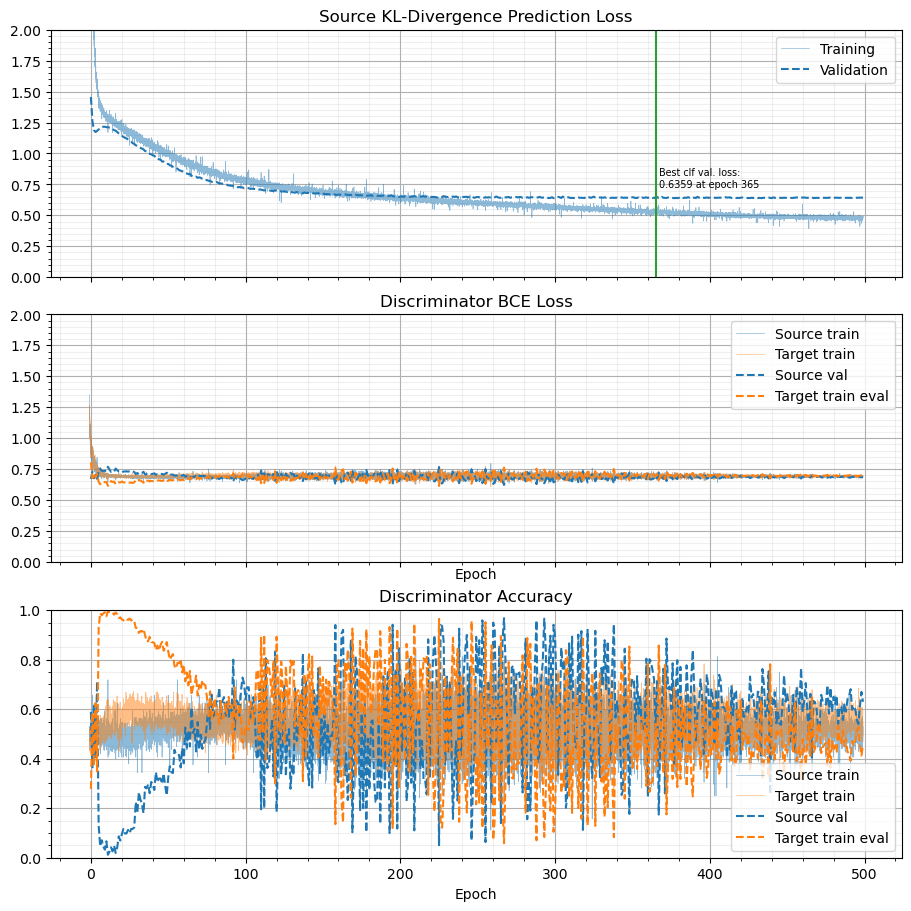

Adversarial training for ST slide 151508: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5701 | 1.5295 ||| 0.9885 | 0.5751 | 1.3324 | 0.9975 || 0.5531 | 0.7654 | 0.4310 | 0.1225 <-- new best val clf loss
     1 ||| 2.9976 | 1.2889 ||| 0.9671 | 0.6377 | 0.9611 | 0.7675 || 0.4873 | 0.6636 | 0.4828 | 0.3360 <-- new best val clf loss
     2 ||| 2.3735 | 1.1717 ||| 0.8800 | 0.7408 | 0.8782 | 0.6504 || 0.5012 | 0.3454 | 0.4961 | 0.6807 <-- new best val clf loss
     3 ||| 1.9950 | 1.1473 ||| 0.8271 | 0.7864 | 0.8265 | 0.6063 || 0.4995 | 0.1108 | 0.5002 | 0.9124 <-- new best val clf loss
     4 ||| 1.7665 | 1.1402 ||| 0.7932 | 0.7284 | 0

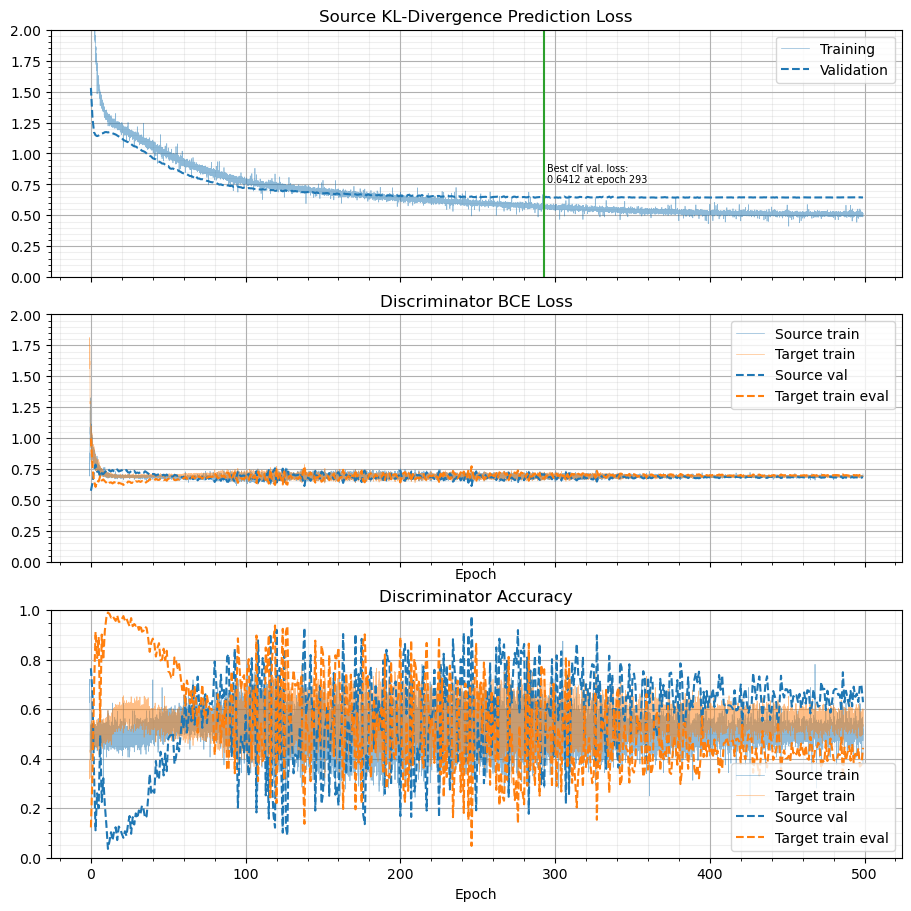

Adversarial training for ST slide 151509: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5054 | 1.6007 ||| 1.2830 | 0.7669 | 1.0029 | 0.7669 || 0.4357 | 0.4432 | 0.5256 | 0.3878 <-- new best val clf loss
     1 ||| 2.7819 | 1.3238 ||| 0.9262 | 0.7208 | 0.9282 | 0.6765 || 0.4896 | 0.4492 | 0.4860 | 0.5805 <-- new best val clf loss
     2 ||| 2.1995 | 1.2023 ||| 0.8555 | 0.6769 | 0.8514 | 0.7221 || 0.4986 | 0.6100 | 0.5015 | 0.3792 <-- new best val clf loss
     3 ||| 1.8644 | 1.1874 ||| 0.8165 | 0.7197 | 0.8184 | 0.6704 || 0.4917 | 0.3164 | 0.4973 | 0.6761 <-- new best val clf loss
     4 ||| 1.6560 | 1.1714 ||| 0.7869 | 0.6878 | 0

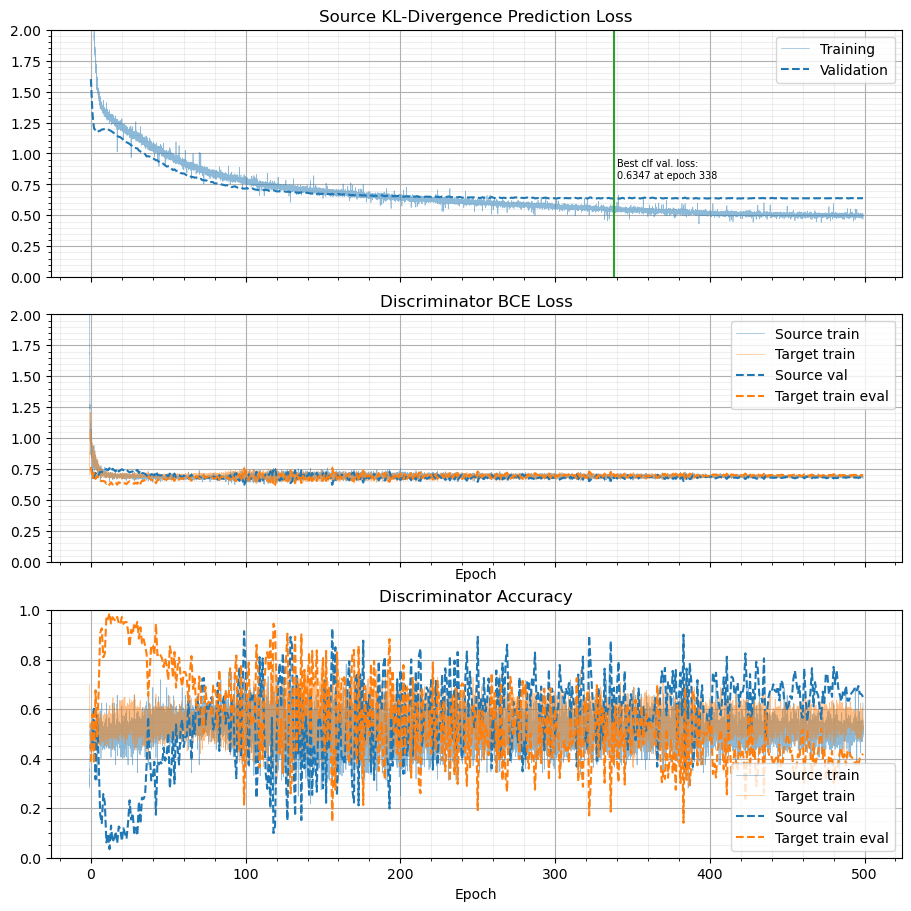

Adversarial training for ST slide 151510: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5761 | 1.5712 ||| 0.9780 | 0.5618 | 1.4456 | 1.1290 || 0.5554 | 0.7624 | 0.4111 | 0.0844 <-- new best val clf loss
     1 ||| 2.8467 | 1.2622 ||| 1.0007 | 0.6575 | 0.9824 | 0.7727 || 0.4686 | 0.6328 | 0.4780 | 0.2926 <-- new best val clf loss
     2 ||| 2.2437 | 1.1719 ||| 0.8931 | 0.7352 | 0.8859 | 0.6411 || 0.4942 | 0.4420 | 0.4950 | 0.6547 <-- new best val clf loss
     3 ||| 1.8878 | 1.1526 ||| 0.8426 | 0.7525 | 0.8288 | 0.6305 || 0.4994 | 0.3412 | 0.5057 | 0.7324 <-- new best val clf loss
     4 ||| 1.6828 | 1.1601 ||| 0.8108 | 0.7267 | 0

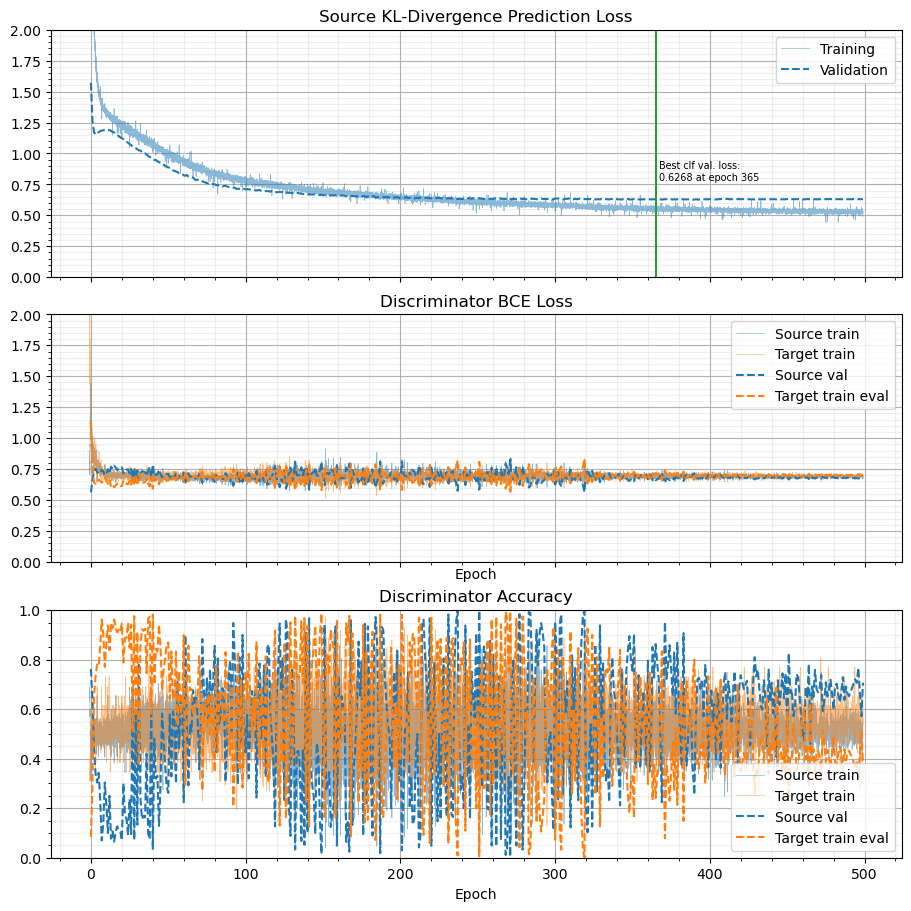

Adversarial training for ST slide 151669: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.4789 | 1.5599 ||| 1.0666 | 0.6933 | 1.0904 | 0.8028 || 0.4945 | 0.5622 | 0.4858 | 0.3330 <-- new best val clf loss
     1 ||| 2.8059 | 1.2712 ||| 0.9023 | 0.7155 | 0.9102 | 0.6879 || 0.4939 | 0.4561 | 0.4892 | 0.5400 <-- new best val clf loss
     2 ||| 2.2142 | 1.1817 ||| 0.8374 | 0.7632 | 0.8420 | 0.6291 || 0.5002 | 0.1474 | 0.4974 | 0.8621 <-- new best val clf loss
     3 ||| 1.8789 | 1.1619 ||| 0.7993 | 0.7276 | 0.8015 | 0.6627 || 0.4989 | 0.3137 | 0.4977 | 0.7132 <-- new best val clf loss
     4 ||| 1.6688 | 1.1579 ||| 0.7762 | 0.6887 | 0

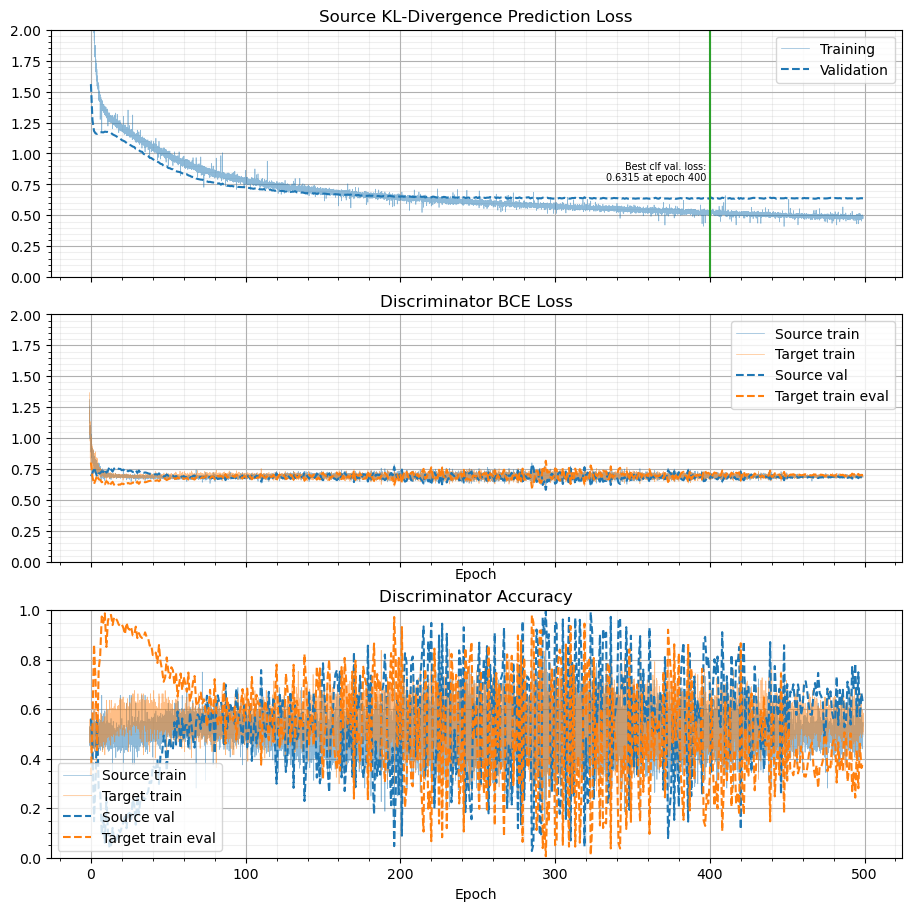

Adversarial training for ST slide 151670: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.6781 | 1.6714 ||| 1.1691 | 0.7634 | 1.1152 | 0.7933 || 0.4732 | 0.4347 | 0.4966 | 0.3788 <-- new best val clf loss
     1 ||| 2.9048 | 1.3326 ||| 0.9213 | 0.6733 | 0.9163 | 0.7240 || 0.4831 | 0.5902 | 0.4844 | 0.4151 <-- new best val clf loss
     2 ||| 2.2609 | 1.2105 ||| 0.8363 | 0.6953 | 0.8299 | 0.6842 || 0.5033 | 0.5346 | 0.4991 | 0.5457 <-- new best val clf loss
     3 ||| 1.8841 | 1.1744 ||| 0.7979 | 0.7234 | 0.7910 | 0.6583 || 0.4975 | 0.3144 | 0.4979 | 0.7604 <-- new best val clf loss
     4 ||| 1.6583 | 1.1662 ||| 0.7662 | 0.7796 | 0

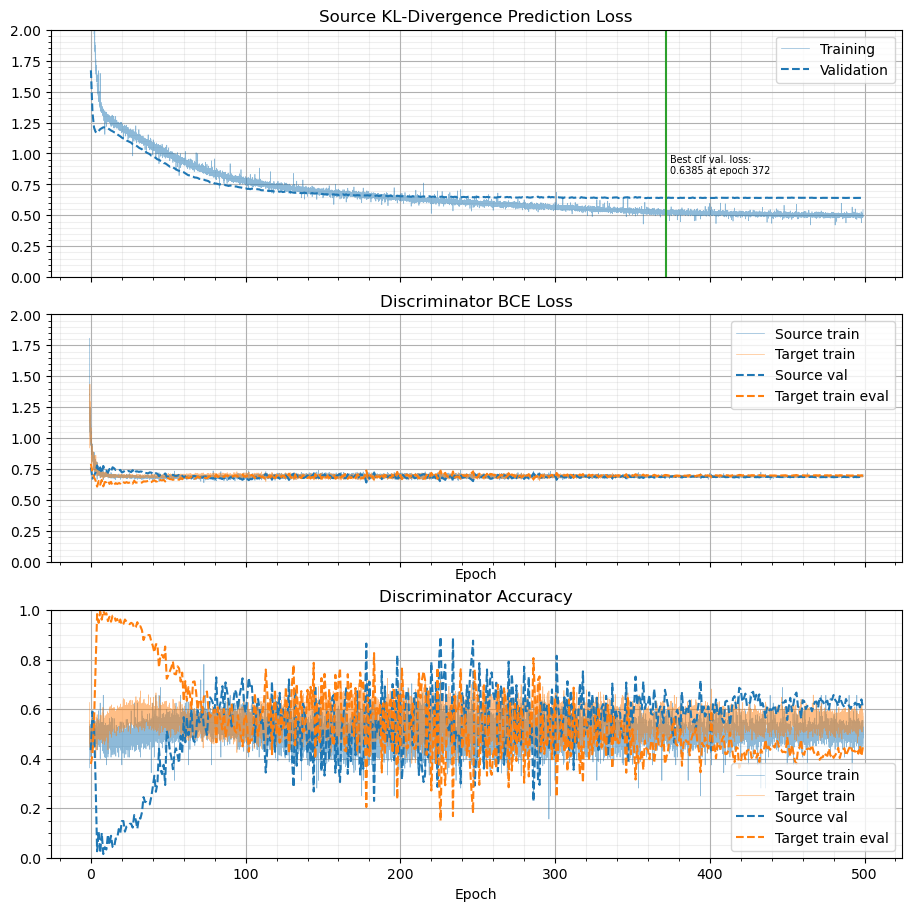

Adversarial training for ST slide 151671: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5913 | 1.5677 ||| 1.1245 | 0.6532 | 1.0875 | 0.8494 || 0.4920 | 0.6240 | 0.4876 | 0.2611 <-- new best val clf loss
     1 ||| 2.9695 | 1.2971 ||| 0.9435 | 0.6395 | 0.9662 | 0.8122 || 0.4950 | 0.6891 | 0.4773 | 0.1949 <-- new best val clf loss
     2 ||| 2.3791 | 1.1879 ||| 0.8745 | 0.7086 | 0.8887 | 0.7133 || 0.4994 | 0.4714 | 0.4867 | 0.4073 <-- new best val clf loss
     3 ||| 1.9996 | 1.1370 ||| 0.8261 | 0.6975 | 0.8437 | 0.7058 || 0.4987 | 0.4835 | 0.4917 | 0.4406 <-- new best val clf loss
     4 ||| 1.7640 | 1.1359 ||| 0.8093 | 0.7186 | 0

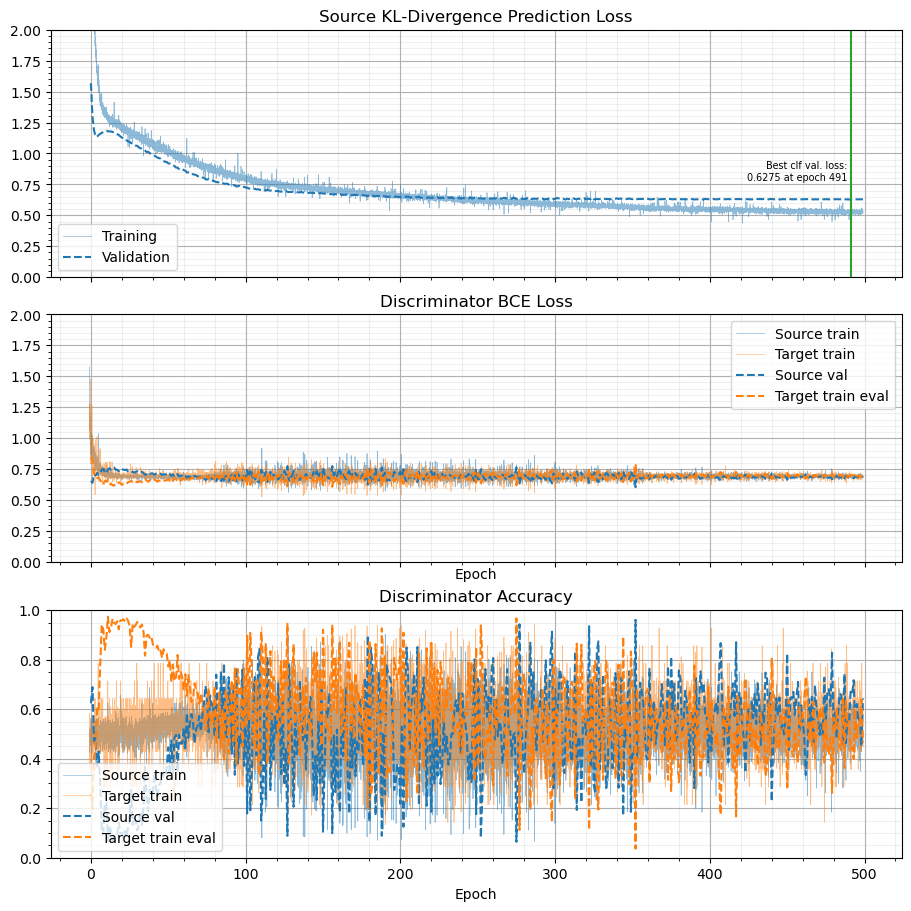

Adversarial training for ST slide 151672: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5719 | 1.5127 ||| 1.1340 | 0.7507 | 1.0388 | 0.7160 || 0.4615 | 0.4115 | 0.5015 | 0.4792 <-- new best val clf loss
     1 ||| 2.8755 | 1.2511 ||| 0.8943 | 0.6603 | 0.8843 | 0.7334 || 0.4909 | 0.6410 | 0.4934 | 0.3781 <-- new best val clf loss
     2 ||| 2.3107 | 1.1588 ||| 0.8295 | 0.6553 | 0.8258 | 0.7309 || 0.5068 | 0.6801 | 0.5029 | 0.3435 <-- new best val clf loss
     3 ||| 1.9649 | 1.1357 ||| 0.7939 | 0.7162 | 0.7963 | 0.6698 || 0.5051 | 0.3209 | 0.4983 | 0.7103 <-- new best val clf loss
     4 ||| 1.7171 | 1.1427 ||| 0.7642 | 0.7437 | 0

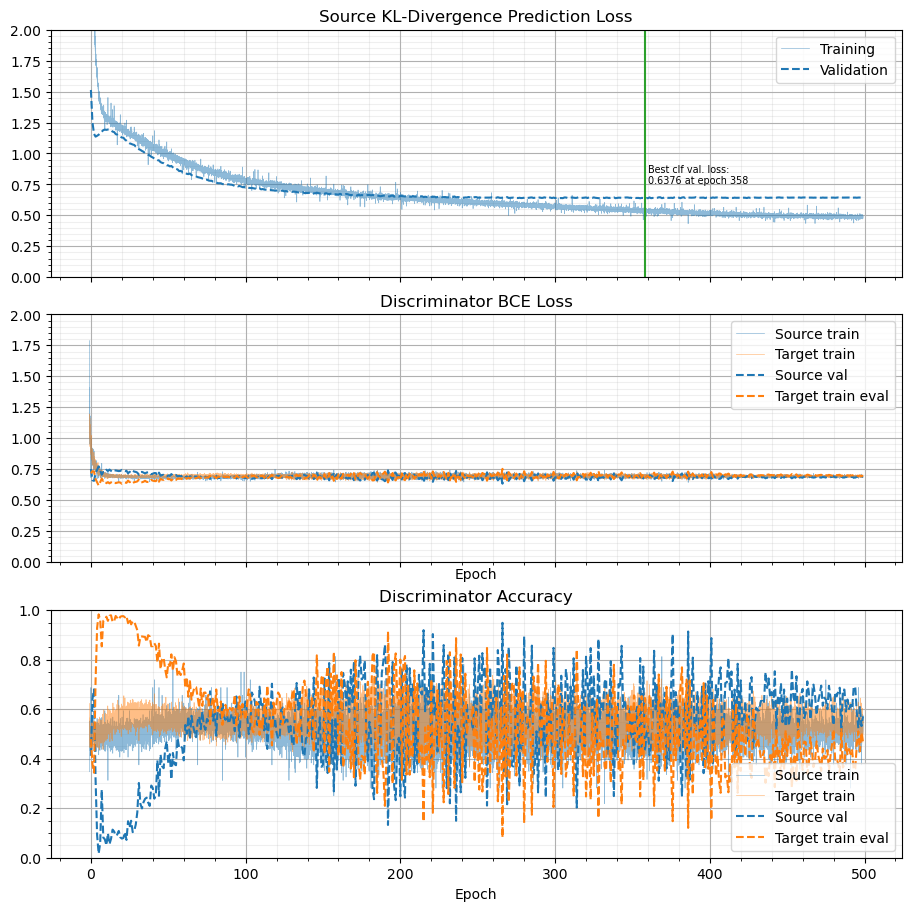

Adversarial training for ST slide 151673: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.7250 | 1.6407 ||| 1.0897 | 0.7686 | 1.1549 | 0.7759 || 0.4996 | 0.3907 | 0.4761 | 0.4592 <-- new best val clf loss
     1 ||| 3.0949 | 1.2831 ||| 0.9261 | 0.6713 | 0.9526 | 0.7705 || 0.4961 | 0.5894 | 0.4899 | 0.3072 <-- new best val clf loss
     2 ||| 2.4332 | 1.1615 ||| 0.8689 | 0.6513 | 0.8715 | 0.7580 || 0.5037 | 0.6866 | 0.4945 | 0.2652 <-- new best val clf loss
     3 ||| 2.0235 | 1.1221 ||| 0.8262 | 0.7205 | 0.8213 | 0.6720 || 0.5003 | 0.3558 | 0.4987 | 0.6540 <-- new best val clf loss
     4 ||| 1.7540 | 1.1301 ||| 0.7854 | 0.7268 | 0

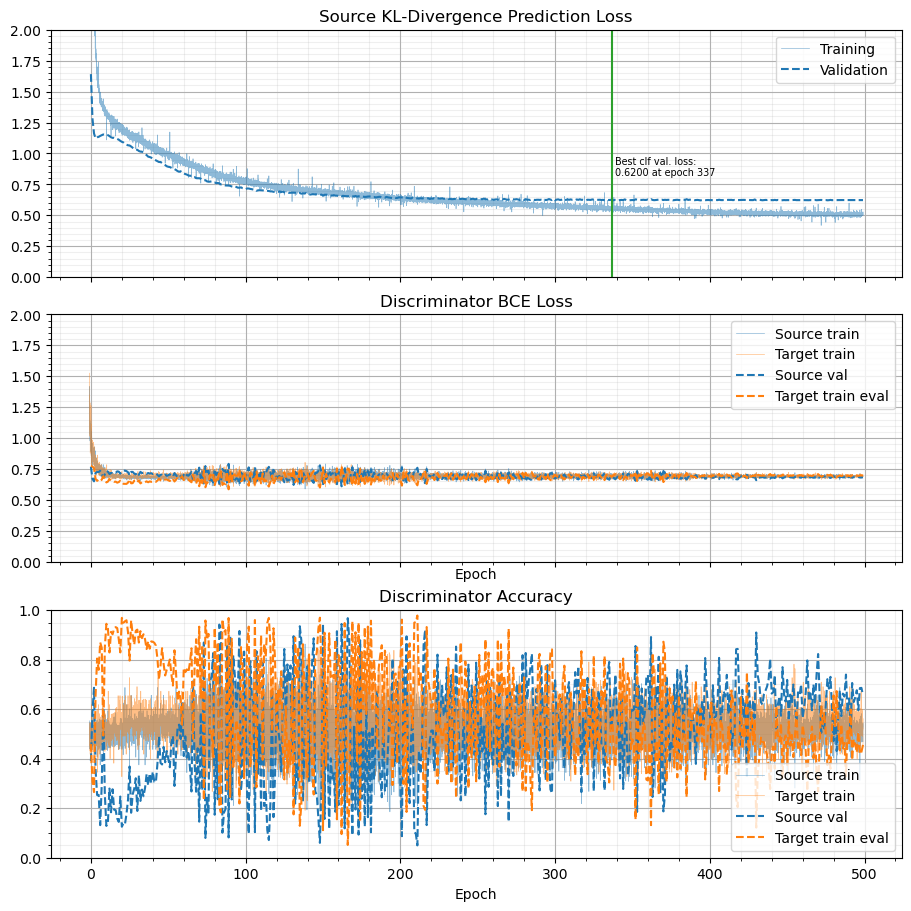

Adversarial training for ST slide 151674: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.5260 | 1.6898 ||| 1.1186 | 0.6819 | 1.1155 | 0.8301 || 0.4800 | 0.5612 | 0.4797 | 0.2883 <-- new best val clf loss
     1 ||| 2.8911 | 1.3294 ||| 0.9032 | 0.6920 | 0.9206 | 0.7112 || 0.4963 | 0.5624 | 0.4818 | 0.4775 <-- new best val clf loss
     2 ||| 2.2777 | 1.1922 ||| 0.8422 | 0.6513 | 0.8417 | 0.7407 || 0.4994 | 0.6843 | 0.5035 | 0.3215 <-- new best val clf loss
     3 ||| 1.9030 | 1.1427 ||| 0.7946 | 0.6902 | 0.7947 | 0.6959 || 0.5061 | 0.5144 | 0.5025 | 0.5276 <-- new best val clf loss
     4 ||| 1.6611 | 1.1438 ||| 0.7656 | 0.7540 | 0

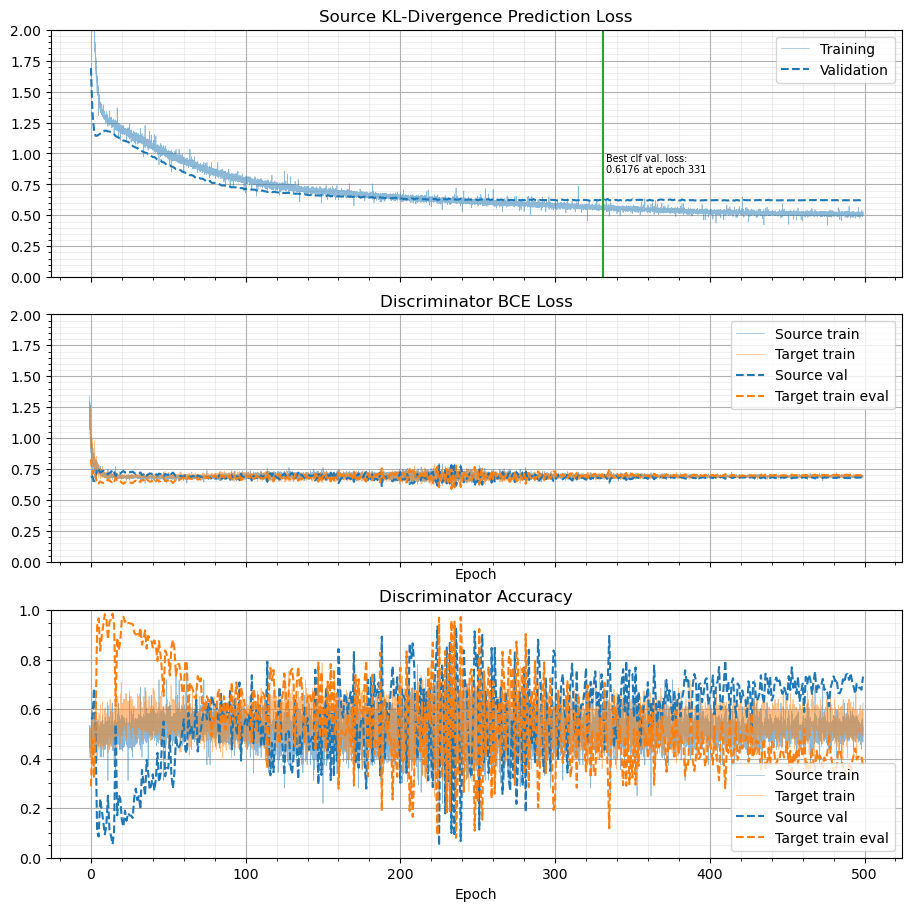

Adversarial training for ST slide 151675: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.8200 | 1.7780 ||| 1.1892 | 0.7742 | 1.1446 | 0.8143 || 0.4727 | 0.4155 | 0.4925 | 0.3719 <-- new best val clf loss
     1 ||| 3.2341 | 1.3996 ||| 1.0049 | 0.5534 | 1.0103 | 0.9650 || 0.4824 | 0.8466 | 0.4807 | 0.0760 <-- new best val clf loss
     2 ||| 2.5928 | 1.2110 ||| 0.9190 | 0.6057 | 0.9453 | 0.8441 || 0.4993 | 0.7661 | 0.4781 | 0.1849 <-- new best val clf loss
     3 ||| 2.2100 | 1.1467 ||| 0.8834 | 0.5665 | 0.8777 | 0.8551 || 0.4952 | 0.9063 | 0.4929 | 0.0933 <-- new best val clf loss
     4 ||| 1.9359 | 1.1142 ||| 0.8358 | 0.6725 | 0

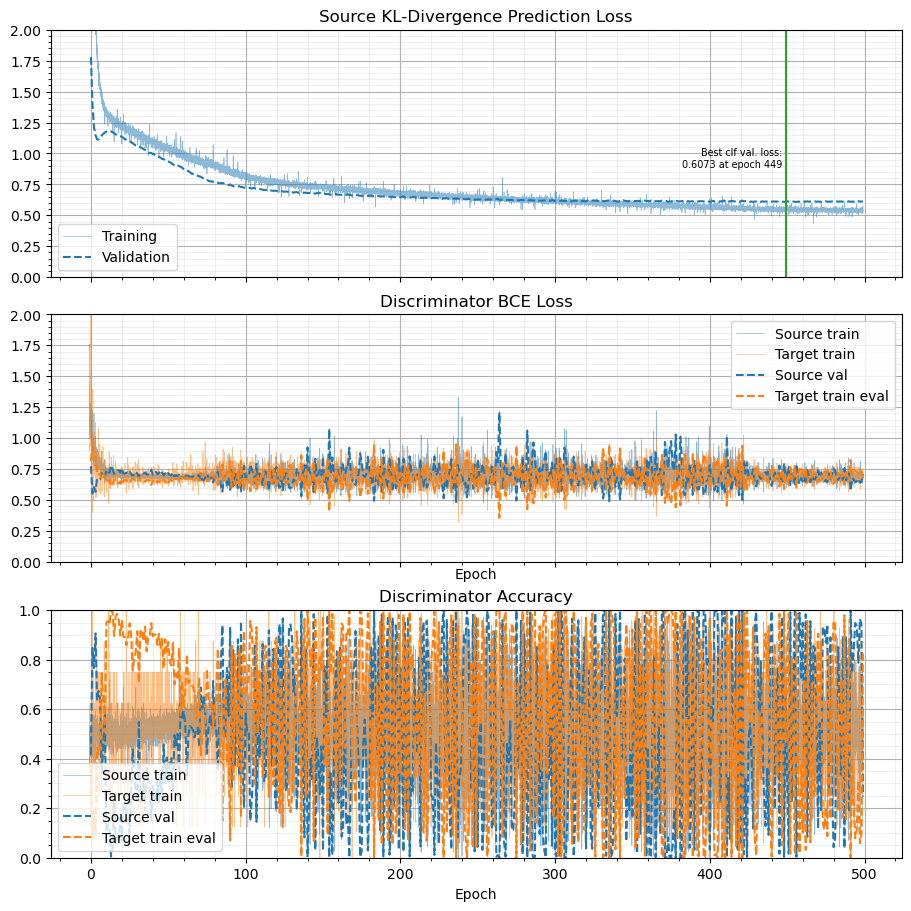

Adversarial training for ST slide 151676: 
Start adversarial training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 4.7080 | 1.6596 ||| 1.0402 | 0.7377 | 1.3159 | 0.8248 || 0.5265 | 0.5094 | 0.4395 | 0.3425 <-- new best val clf loss
     1 ||| 2.9610 | 1.3432 ||| 0.9525 | 0.6941 | 0.9633 | 0.7048 || 0.4914 | 0.5255 | 0.4905 | 0.4913 <-- new best val clf loss
     2 ||| 2.2831 | 1.2097 ||| 0.8589 | 0.7204 | 0.8799 | 0.6777 || 0.5078 | 0.4251 | 0.5015 | 0.5957 <-- new best val clf loss
     3 ||| 1.9066 | 1.1576 ||| 0.8248 | 0.7116 | 0.8263 | 0.6796 || 0.4925 | 0.3981 | 0.4901 | 0.6046 <-- new best val clf loss
     4 ||| 1.6620 | 1.1596 ||| 0.7837 | 0.7242 | 0

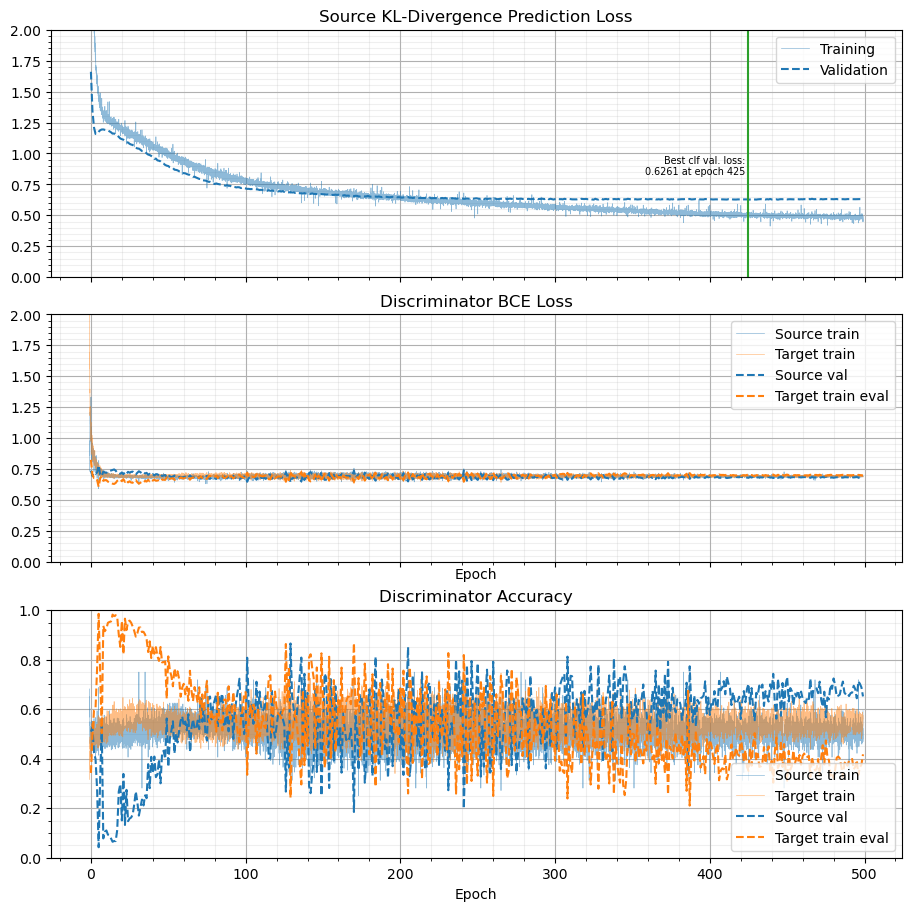

In [19]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    model = DANN(
        sc_mix_d["train"].shape[1],
        emb_dim=64,
        ncls_source=lab_mix_d["train"].shape[1],
        alpha_=ALPHA,
    )
    model.apply(initialize_weights)
    if PRETRAINING:
        best_pre_checkpoint = torch.load(
            os.path.join(pretrain_folder, f"final_model.pth")
        )
        model.load_state_dict(best_pre_checkpoint["model"].state_dict())
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        model = DANN(
            sc_mix_d["train"].shape[1],
            emb_dim=64,
            ncls_source=lab_mix_d["train"].shape[1],
            alpha_=ALPHA,
        )
        model.apply(initialize_weights)

        if PRETRAINING:
            best_pre_checkpoint = torch.load(
                os.path.join(pretrain_folder, f"final_model.pth")
            )
            model.load_state_dict(best_pre_checkpoint["model"].state_dict())
        model.to(device)

        model.advtraining()

        training_history = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
        )

        with open(os.path.join(save_folder, "training_history.pkl"), "wb") as f:
            pickle.dump(training_history, f)

        plot_results(*training_history, save_folder)
